In [1]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
import optuna
import mlflow
from sklearn.model_selection import GridSearchCV
from pmdarima.arima import auto_arima
from keras.models import load_model
import joblib
from weatherapi import WeatherPoint
import requests
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import pickle
from pmdarima.arima import auto_arima
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt
from keras.models import load_model
import pandas as pd
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense, LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from datetime import datetime
import pandas as pd
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import xgboost as xgb

#root_path = "/projects/app" #это если в контейнере 
root_path = "."  #это если в локальной машине
path_data = f'{root_path}/data'
your_mlflow_tracking_uri = f'{root_path}/mlruns'

mlflow.set_tracking_uri(your_mlflow_tracking_uri)

### 0. This file for time series models training

The data is provided by the website "Reliable Prognosis", rp5.ru

## 1. sarimax grid search

In [16]:
data = pd.read_excel('data/archive.xls')

In [17]:
data

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.base import BaseEstimator, RegressorMixin

# Преобразование столбца 'Local time in Moscow' в формат datetime и установка его в качестве индекса
data['Local time in Moscow'] = pd.to_datetime(data['Local time in Moscow'], format='%d.%m.%Y %H:%M')
data.set_index('Local time in Moscow', inplace=True)

# Выбор столбца с температурой для прогнозирования
temperature = data['T']

data = data.loc[data.index > '2022-01-01']

# Заполнение пропущенных значений в столбце 'T' средним значением
data['T'].fillna(data['T'].mean(), inplace=True)

# Разделение данных на тренировочный и тестовый наборы по времени
train = data.loc[data.index < '2023-01-01']
test = data.loc[data.index >= '2023-01-01']
endog_column = 'T'  # Замените 'T' на фактическое имя столбца, содержащее целевую переменную
endog_train = train[endog_column]
endog_test = test[endog_column]

param_grid = {
    'order': [(0, 0, 0), (1, 1, 1), (1, 1, 2), (2, 1, 1), (2, 1, 2), (2, 1, 30)],  # расширенный диапазон значений для параметров (p, d, q)
    'seasonal_order': [(1, 1, 1, 12), (1, 1, 2, 12), (2, 1, 1, 12), (2, 1, 2, 12)]  # расширенный диапазон значений для сезонных параметров (P, D, Q, S)
}

class SARIMAXWrapper(BaseEstimator, RegressorMixin):
    def __init__(self, order=(1, 1, 1), seasonal_order=(1, 1, 1, 12)):
        self.order = order
        self.seasonal_order = seasonal_order

    def fit(self, X, y=None):
        self.model = SARIMAX(X, order=self.order, seasonal_order=self.seasonal_order)
        self.results = self.model.fit()
        return self

    def predict(self, X, y=None):
        return self.results.forecast(steps=len(X))

# Создание и обучение модели SARIMA с использованием GridSearchCV
model = SARIMAXWrapper()
grid_search = GridSearchCV(model, param_grid, scoring='neg_mean_squared_error', cv=3, n_jobs=-1)
grid_search.fit(endog_train.values.reshape(-1, 1), endog_train)

# Получение наилучших гиперпараметров
best_params = grid_search.best_params_
print("Best Parameters:", best_params)

# Создание и обучение модели SARIMA с наилучшими найденными параметрами
best_model = SARIMAXWrapper(order=best_params['order'], seasonal_order=best_params['seasonal_order'])
best_model.fit(endog_train.values.reshape(-1, 1))

# Прогнозирование на тестовом наборе с использованием наилучшей модели
forecast = best_model.predict(endog_test.values.reshape(-1, 1))

# Оценка производительности наилучшей модели
mse = mean_squared_error(endog_test, forecast)
print('Mean Squared Error (Best Model):', mse)

# Визуализация результатов
plt.figure(figsize=(12, 6))
plt.plot(endog_test.index, endog_test, label='Фактическая температура')
plt.plot(endog_test.index, forecast, color='red', label='Прогноз температуры')
plt.title('Прогноз температуры с помощью SARIMA (с оптимизацией гиперпараметров)')
plt.xlabel('Дата')
plt.ylabel('Температура')
plt.legend()
plt.show()


#### 2. xgb 

In [144]:

# Load data
data = pd.read_excel('data/archive.xls')

data['T'] = data['T'].interpolate(method='linear')

data = data[['Local time in Moscow', 'T']]

data['Local time in Moscow'] = pd.to_datetime(data['Local time in Moscow'], format='%d.%m.%Y %H:%M')

train = data.loc[data['Local time in Moscow'] < '2023-01-01']
test = data.loc[data['Local time in Moscow'] >= '2023-01-01']

# Preprocess data
X_train = train['Local time in Moscow']
X_test = test['Local time in Moscow']
y_train = train['T']
y_test = test['T']


# Extract datetime features
X_train_features = pd.DataFrame()
X_train_features['year'] = X_train.dt.year
X_train_features['month'] = X_train.dt.month
X_train_features['day'] = X_train.dt.day
X_train_features['hour'] = X_train.dt.hour

X_test_features = pd.DataFrame()
X_test_features['year'] = X_test.dt.year
X_test_features['month'] = X_test.dt.month
X_test_features['day'] = X_test.dt.day
X_test_features['hour'] = X_test.dt.hour

# Create and fit XGBoost model
my_xgb = xgb.XGBRegressor()
my_xgb.fit(X_train_features, y_train)

# Make predictions
forecast = my_xgb.predict(X_test_features)

# Visualize results
plt.figure(figsize=(12, 6))
plt.plot(X_test, y_test, label='Actual temperature')
plt.plot(X_test, forecast, color='red', label='Predicted temperature')
plt.title('Temperature Forecast using XGBoost')
plt.xlabel('Date')
plt.ylabel('Temperature')
plt.legend()
plt.show()


In [3]:


# Загрузите новые данные и предобработайте их, извлекая признаки
# Пример: новые данные хранятся в переменной new_data
new_data = ['2024-05-31 21:00:00']

def temp_pred_xgb(data,model):    
    # Преобразуйте новые данные в DataFrame и укажите правильное имя столбца
    data_df = pd.DataFrame(data, columns=['Local time in Moscow'])
    data_df['Local time in Moscow'] = pd.to_datetime(data_df['Local time in Moscow'], format='%Y-%m-%d %H:%M:%S')
    
    # Извлеките признаки из новых данных
    data_features = pd.DataFrame()
    data_features['year'] = data_df['Local time in Moscow'].dt.year
    data_features['month'] = data_df['Local time in Moscow'].dt.month
    data_features['day'] = data_df['Local time in Moscow'].dt.day
    data_features['hour'] = data_df['Local time in Moscow'].dt.hour

    # Сделайте предсказания
    predictions = model.predict(data_features)
    return predictions[0]

In [7]:


# Сохранение модели
#joblib.dump(my_xgb, 'back/my_xgb_model.joblib')

# Загрузка модели
loaded_model = joblib.load('back/my_catb_model.joblib')


In [8]:
new_data = ['2024-06-28 12:00:00']


In [9]:
temp_pred_xgb(new_data,loaded_model)

#### 3. Catboost

In [59]:

# Load data
data = pd.read_excel('data/archive.xlsx')

data['T'] = data['T'].interpolate(method='linear')

data = data[['Local time in Moscow', 'T']]

data['Local time in Moscow'] = pd.to_datetime(data['Local time in Moscow'], format='%d.%m.%Y %H:%M')

train = data.loc[data['Local time in Moscow'] < '2023-01-01']
test = data.loc[data['Local time in Moscow'] >= '2023-01-01']

# Preprocess data
X_train = train['Local time in Moscow']
X_test = test['Local time in Moscow']
y_train = train['T']
y_test = test['T']

# Extract datetime features
X_train_features = pd.DataFrame()
X_train_features['year'] = X_train.dt.year
X_train_features['month'] = X_train.dt.month
X_train_features['day'] = X_train.dt.day
X_train_features['hour'] = X_train.dt.hour

X_test_features = pd.DataFrame()
X_test_features['year'] = X_test.dt.year
X_test_features['month'] = X_test.dt.month
X_test_features['day'] = X_test.dt.day
X_test_features['hour'] = X_test.dt.hour

# Create and fit CatBoost model
my_catboost = CatBoostRegressor()
my_catboost.fit(X_train_features, y_train)

# Make predictions
forecast = my_catboost.predict(X_test_features)

# Visualize results
plt.figure(figsize=(12, 6))
plt.plot(X_test, y_test, label='Actual temperature')
plt.plot(X_test, forecast, color='red', label='Predicted temperature')
plt.title('Temperature Forecast using CatBoost')
plt.xlabel('Date')
plt.ylabel('Temperature')
plt.legend()
plt.show()


In [3]:
# Сохранение модели
joblib.dump(my_catboost, 'back/my_catb_model.joblib')


In [8]:

# Загрузка модели
loaded_model = joblib.load('back/my_catb_model.joblib')

In [66]:
# Загрузка модели
catboost_model = CatBoostRegressor()
catboost_model.load_model('back/catboost_model.bin')

# Теперь вы можете использовать загруженную модель для прогнозирования
new_data = ['2022-01-14 21:00:00']

temp_pred_xgb(data=new_data,model=catboost_model)

In [14]:
# Загрузите новые данные и предобработайте их, извлекая признаки
# Пример: новые данные хранятся в переменной new_data
new_data = ['2024-09-14 21:00:00']

temp_pred_xgb(data=new_data,model=loaded_model)

In [15]:

def current_time_to_str():
    # Получить текущее время
    current_time = datetime.now()
    # Преобразовать в строку в нужном формате
    formatted_time = current_time.strftime('%Y-%m-%d %H:%M:%S')
    return formatted_time

# Пример использования функции
formatted_current_time = current_time_to_str()
print(formatted_current_time)


### MFLOW

In [ ]:
mlflow_callback = MLflowCallback(
    tracking_uri=your_mlflow_tracking_uri,  # Set your MLflow tracking URI
    metric_name='mae'
)

# Optuna study
study = optuna.create_study(direction='minimize', study_name='CatBoost Optimization')
study.optimize(objective, n_trials=200, callbacks=[mlflow_callback])

#### XGB optimize with OPTUNA

In [11]:
from mlflow import MlflowClient


In [21]:
local_dir = ('C:/Users/Peter/DataspellProjects/kaggle/airflow_train1')

# mlflow.set_tracking_uri(uri='http://127.0.0.1:8010')
# client = MlflowClient(tracking_uri='http://127.0.0.1:8010')

mlflow.set_tracking_uri(uri='http://127.0.0.1:5000')
client = MlflowClient()



In [2]:
import xgboost as xgb
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error
import optuna
import mlflow

# Load data
data = pd.read_excel('data/archive.xlsx')

data['T'] = data['T'].interpolate(method='linear')

data = data[['Local time in Moscow', 'T']]

data['Local time in Moscow'] = pd.to_datetime(data['Local time in Moscow'], format='%d.%m.%Y %H:%M')

train = data.loc[data['Local time in Moscow'] < '2023-01-01']
test = data.loc[data['Local time in Moscow'] >= '2023-01-01']

# Preprocess data
X_train = train['Local time in Moscow']
X_test = test['Local time in Moscow']
y_train = train['T']
y_test = test['T']

# Extract datetime features
X_train_features = pd.DataFrame()
X_train_features['year'] = X_train.dt.year
X_train_features['month'] = X_train.dt.month
X_train_features['day'] = X_train.dt.day
X_train_features['hour'] = X_train.dt.hour

X_test_features = pd.DataFrame()
X_test_features['year'] = X_test.dt.year
X_test_features['month'] = X_test.dt.month
X_test_features['day'] = X_test.dt.day
X_test_features['hour'] = X_test.dt.hour

def objective(trial):
    params = {
        'objective': 'reg:squarederror',
        'eval_metric': 'rmse',
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.001, 0.1),
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000, step=100),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 0, 10),
        'reg_lambda': trial.suggest_float('reg_lambda', 0, 10)
    }

    my_xgb = xgb.XGBRegressor(**params)
    my_xgb.fit(X_train_features, y_train)

    forecast = my_xgb.predict(X_test_features)

    mse = mean_squared_error(y_test, forecast)
    mae = mean_absolute_error(y_test, forecast)

    with mlflow.start_run(run_name='xgb_optuna_temperature_run'):
        mlflow.log_params(params)
        mlflow.log_metric("mse", mse)
        mlflow.log_metric("mae", mae)

    return mse

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100)

print("Number of finished trials: ", len(study.trials))
print("Best trial:")
best_trial = study.best_trial

print("  Value: ", best_trial.value)
print("  Params: ")
for key, value in best_trial.params.items():
    print("    {}: {}".format(key, value))

# Visualize results
plt.figure(figsize=(12, 6))
plt.plot(X_test, y_test, label='Actual temperature')

# Using the best trial to predict
best_params = best_trial.params
best_xgb = xgb.XGBRegressor(**best_params)
best_xgb.fit(X_train_features, y_train)
forecast = best_xgb.predict(X_test_features)

plt.plot(X_test, forecast, color='red', label='Predicted temperature')
plt.title('Temperature Forecast using XGBoost')
plt.xlabel('Date')
plt.ylabel('Temperature')
plt.legend()
plt.show()


KeyboardInterrupt: 

In [27]:
"""
Best trial:
  Value:  25.911588656739834
  Params: 
    max_depth: 4
    learning_rate: 0.01161217681023573
    n_estimators: 1000
    subsample: 0.918976174252799
    colsample_bytree: 0.8163223167040442
    reg_alpha: 8.62413827273403
    reg_lambda: 5.947117310322002
"""

#### XGBoost with callbacks

C:\Users\Peter\AppData\Local\Temp\ipykernel_12084\3950863629.py:81: ExperimentalWarning: MLflowCallback is experimental (supported from v1.4.0). The interface can change in the future.
  mlflow_callback = MLflowCallback(
[I 2024-06-05 22:32:23,557] A new study created in memory with name: XGBoost Optimization
[I 2024-06-05 22:32:28,869] Trial 0 finished with value: 26.10820115182802 and parameters: {'max_depth': 4, 'learning_rate': 0.07915081390251481, 'n_estimators': 200, 'subsample': 0.9800598431561471, 'colsample_bytree': 0.750020252925968, 'reg_alpha': 8.73679266346882, 'reg_lambda': 6.304675272432907}. Best is trial 0 with value: 26.10820115182802.
2024/06/05 22:32:28 INFO mlflow.tracking.fluent: Experiment with name 'XGBoost Optimization' does not exist. Creating a new experiment.
[I 2024-06-05 22:32:32,756] Trial 1 finished with value: 30.136341616783348 and parameters: {'max_depth': 10, 'learning_rate': 0.03931802680535605, 'n_estimators': 200, 'subsample': 0.5058551504144665, 

Number of finished trials:  100
Best trial:
  Value:  25.470447770027533
  Params: 
    max_depth: 3
    learning_rate: 0.034363055296330644
    n_estimators: 400
    subsample: 0.8329464727783494
    colsample_bytree: 0.6831807948376526
    reg_alpha: 0.4494066071143523
    reg_lambda: 1.7904389084057692


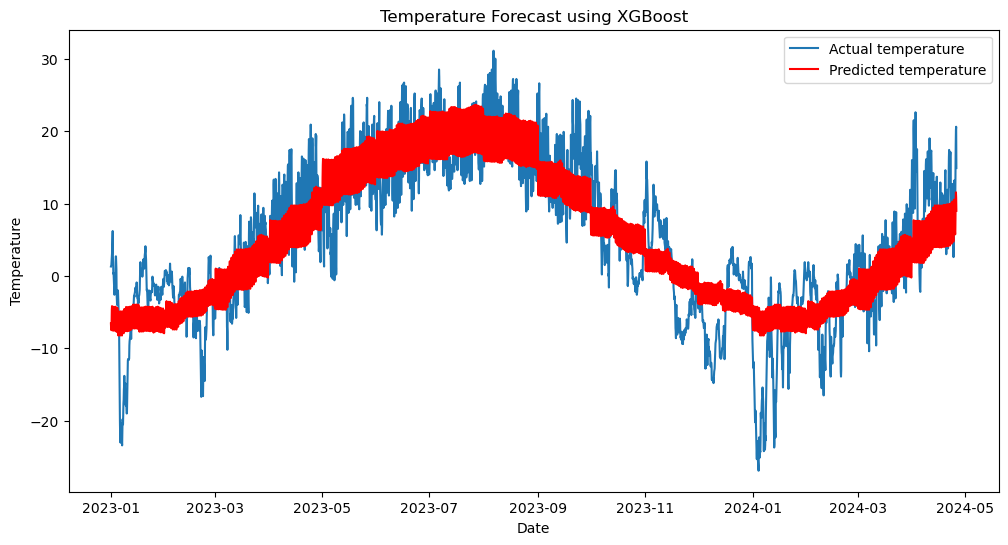

In [3]:
import xgboost as xgb
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error
import optuna
from optuna.integration.mlflow import MLflowCallback
import mlflow
from mlflow.entities import RunStatus

# Set your MLflow tracking URI
mlflow_tracking_uri = 'http://localhost:5000'  # Замените на ваш действительный URI
mlflow.set_tracking_uri(mlflow_tracking_uri)

# Завершаем все активные запуски, если они есть
if mlflow.active_run() is not None:
    mlflow.end_run(status=RunStatus.FAILED)

# Load data
data = pd.read_excel('data/archive.xlsx')

data['T'] = data['T'].interpolate(method='linear')

data = data[['Local time in Moscow', 'T']]

data['Local time in Moscow'] = pd.to_datetime(data['Local time in Moscow'], format='%d.%m.%Y %H:%M')

train = data.loc[data['Local time in Moscow'] < '2023-01-01']
test = data.loc[data['Local time in Moscow'] >= '2023-01-01']

# Preprocess data
X_train = train['Local time in Moscow']
X_test = test['Local time in Moscow']
y_train = train['T']
y_test = test['T']

# Extract datetime features
X_train_features = pd.DataFrame()
X_train_features['year'] = X_train.dt.year
X_train_features['month'] = X_train.dt.month
X_train_features['day'] = X_train.dt.day
X_train_features['hour'] = X_train.dt.hour

X_test_features = pd.DataFrame()
X_test_features['year'] = X_test.dt.year
X_test_features['month'] = X_test.dt.month
X_test_features['day'] = X_test.dt.day
X_test_features['hour'] = X_test.dt.hour

def objective(trial):
    # Завершаем все активные запуски, если они есть
    if mlflow.active_run() is not None:
        mlflow.end_run(status=RunStatus.FAILED)

    with mlflow.start_run(nested=True):
        params = {
            'objective': 'reg:squarederror',
            'eval_metric': 'rmse',
            'max_depth': trial.suggest_int('max_depth', 3, 10),
            'learning_rate': trial.suggest_float('learning_rate', 0.001, 0.1),
            'n_estimators': trial.suggest_int('n_estimators', 100, 1000, step=100),
            'subsample': trial.suggest_float('subsample', 0.5, 1.0),
            'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
            'reg_alpha': trial.suggest_float('reg_alpha', 0, 10),
            'reg_lambda': trial.suggest_float('reg_lambda', 0, 10)
        }

        my_xgb = xgb.XGBRegressor(**params)
        my_xgb.fit(X_train_features, y_train)

        forecast = my_xgb.predict(X_test_features)

        mse = mean_squared_error(y_test, forecast)
        mae = mean_absolute_error(y_test, forecast)

        mlflow.log_params(params)
        mlflow.log_metric("mse", mse)
        mlflow.log_metric("mae", mae)

    return mse

mlflow_callback = MLflowCallback(
    tracking_uri=mlflow_tracking_uri,  # Set your MLflow tracking URI
    metric_name='mae'
)

# Optuna study
study = optuna.create_study(direction='minimize', study_name='XGBoost Optimization')
study.optimize(objective, n_trials=100, callbacks=[mlflow_callback])

print("Number of finished trials: ", len(study.trials))
print("Best trial:")
best_trial = study.best_trial

print("  Value: ", best_trial.value)
print("  Params: ")
for key, value in best_trial.params.items():
    print("    {}: {}".format(key, value))

# Visualize results
plt.figure(figsize=(12, 6))
plt.plot(X_test, y_test, label='Actual temperature')

# Using the best trial to predict
best_params = best_trial.params
best_xgb = xgb.XGBRegressor(**best_params)
best_xgb.fit(X_train_features, y_train)
forecast = best_xgb.predict(X_test_features)

plt.plot(X_test, forecast, color='red', label='Predicted temperature')
plt.title('Temperature Forecast using XGBoost')
plt.xlabel('Date')
plt.ylabel('Temperature')
plt.legend()
plt.show()


Best trial:
  Value:  25.54487777513459
  Params: 
    max_depth: 3
    learning_rate: 0.033622439705080165
    n_estimators: 300
    subsample: 0.6613391981920586
    colsample_bytree: 0.9519651268821888
    reg_alpha: 4.547704971968189
    reg_lambda: 6.198893325029587

## CatBoost with callbacks

C:\Users\Peter\AppData\Local\Temp\ipykernel_12084\3810609916.py:78: ExperimentalWarning: MLflowCallback is experimental (supported from v1.4.0). The interface can change in the future.
  mlflow_callback = MLflowCallback(
[I 2024-06-05 22:39:31,372] A new study created in memory with name: CatBoost Optimization
[I 2024-06-05 22:39:32,261] Trial 0 finished with value: 31.26842558842824 and parameters: {'depth': 8, 'learning_rate': 0.016239790260722413, 'iterations': 100, 'subsample': 0.9557754454159844, 'colsample_bylevel': 0.8326123817411584, 'l2_leaf_reg': 5.170457113398484}. Best is trial 0 with value: 31.26842558842824.
2024/06/05 22:39:32 INFO mlflow.tracking.fluent: Experiment with name 'CatBoost Optimization' does not exist. Creating a new experiment.
[I 2024-06-05 22:39:35,141] Trial 1 finished with value: 25.23080417351223 and parameters: {'depth': 4, 'learning_rate': 0.017925720879166714, 'iterations': 800, 'subsample': 0.9319486665790122, 'colsample_bylevel': 0.620854709064536

Number of finished trials:  100
Best trial:
  Value:  24.9804668230354
  Params: 
    depth: 5
    learning_rate: 0.0612619216802394
    iterations: 200
    subsample: 0.5826341720989494
    colsample_bylevel: 0.5865052215054685
    l2_leaf_reg: 0.7318952177271218


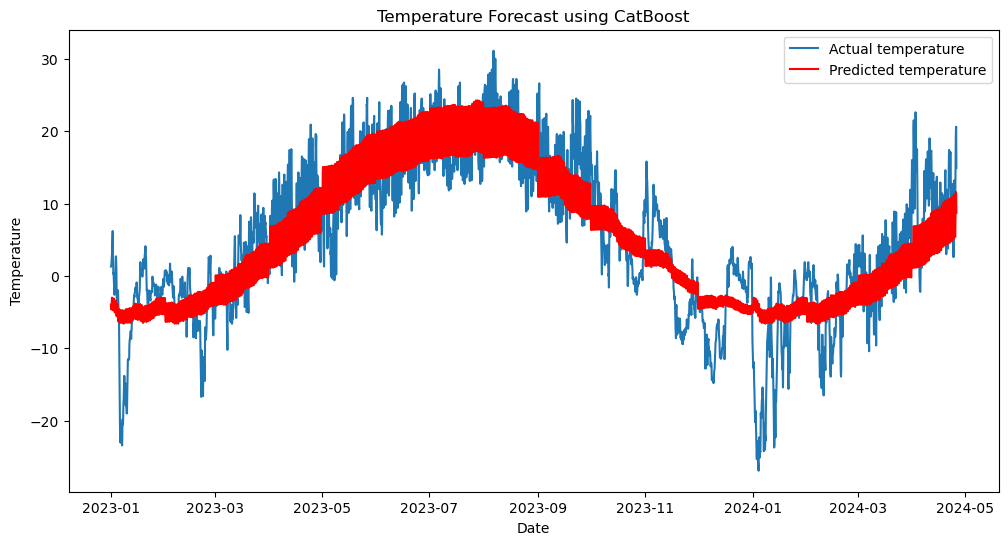

In [4]:
import catboost as cb
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error
import optuna
from optuna.integration.mlflow import MLflowCallback
import mlflow
from mlflow.entities import RunStatus

# Set your MLflow tracking URI
mlflow_tracking_uri = 'http://localhost:5000'  # Замените на ваш действительный URI
mlflow.set_tracking_uri(mlflow_tracking_uri)

# Завершаем все активные запуски, если они есть
if mlflow.active_run() is not None:
    mlflow.end_run(status=RunStatus.FAILED)

# Load data
data = pd.read_excel('data/archive.xlsx')

data['T'] = data['T'].interpolate(method='linear')

data = data[['Local time in Moscow', 'T']]

data['Local time in Moscow'] = pd.to_datetime(data['Local time in Moscow'], format='%d.%m.%Y %H:%M')

train = data.loc[data['Local time in Moscow'] < '2023-01-01']
test = data.loc[data['Local time in Moscow'] >= '2023-01-01']

# Preprocess data
X_train = train['Local time in Moscow']
X_test = test['Local time in Moscow']
y_train = train['T']
y_test = test['T']

# Extract datetime features
X_train_features = pd.DataFrame()
X_train_features['year'] = X_train.dt.year
X_train_features['month'] = X_train.dt.month
X_train_features['day'] = X_train.dt.day
X_train_features['hour'] = X_train.dt.hour

X_test_features = pd.DataFrame()
X_test_features['year'] = X_test.dt.year
X_test_features['month'] = X_test.dt.month
X_test_features['day'] = X_test.dt.day
X_test_features['hour'] = X_test.dt.hour

def objective(trial):
    # Завершаем все активные запуски, если они есть
    if mlflow.active_run() is not None:
        mlflow.end_run(status=RunStatus.FAILED)

    with mlflow.start_run(nested=True):
        params = {
            'depth': trial.suggest_int('depth', 3, 10),
            'learning_rate': trial.suggest_float('learning_rate', 0.001, 0.1),
            'iterations': trial.suggest_int('iterations', 100, 1000, step=100),
            'subsample': trial.suggest_float('subsample', 0.5, 1.0),
            'colsample_bylevel': trial.suggest_float('colsample_bylevel', 0.5, 1.0),
            'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 0, 10)
        }

        my_cb = cb.CatBoostRegressor(**params, silent=True)
        my_cb.fit(X_train_features, y_train)

        forecast = my_cb.predict(X_test_features)

        mse = mean_squared_error(y_test, forecast)
        mae = mean_absolute_error(y_test, forecast)

        mlflow.log_params(params)
        mlflow.log_metric("mse", mse)
        mlflow.log_metric("mae", mae)

    return mse

mlflow_callback = MLflowCallback(
    tracking_uri=mlflow_tracking_uri,  # Set your MLflow tracking URI
    metric_name='mae'
)

# Optuna study
study = optuna.create_study(direction='minimize', study_name='CatBoost Optimization')
study.optimize(objective, n_trials=100, callbacks=[mlflow_callback])

print("Number of finished trials: ", len(study.trials))
print("Best trial:")
best_trial = study.best_trial

print("  Value: ", best_trial.value)
print("  Params: ")
for key, value in best_trial.params.items():
    print("    {}: {}".format(key, value))

# Visualize results
plt.figure(figsize=(12, 6))
plt.plot(X_test, y_test, label='Actual temperature')

# Using the best trial to predict
best_params = best_trial.params
best_cb = cb.CatBoostRegressor(**best_params, silent=True)
best_cb.fit(X_train_features, y_train)
forecast = best_cb.predict(X_test_features)

plt.plot(X_test, forecast, color='red', label='Predicted temperature')
plt.title('Temperature Forecast using CatBoost')
plt.xlabel('Date')
plt.ylabel('Temperature')
plt.legend()
plt.show()


#### SARIMA with Optuna

In [34]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error, mean_absolute_error
import optuna
import mlflow

# Load data
data = pd.read_excel('data/archive.xlsx')

# Interpolate missing temperature values
data['T'] = data['T'].interpolate(method='linear')

# Select relevant columns and convert to datetime
data = data[['Local time in Moscow', 'T']]
data['Local time in Moscow'] = pd.to_datetime(data['Local time in Moscow'], format='%d.%m.%Y %H:%M')

# Sort data by datetime to ensure monotonicity
data.sort_values(by='Local time in Moscow', inplace=True)
data.set_index('Local time in Moscow', inplace=True)

# Ensure frequency is set
data = data.asfreq('H')

# Split data into training and test sets
train = data.loc[data.index < '2023-01-01']
test = data.loc[data.index >= '2023-01-01']

# Separate features and target
y_train = train['T']
y_test = test['T']

# Ensure there are no NaN values in y_train and y_test
y_train = y_train.dropna()
y_test = y_test.dropna()

def sarima_objective(trial):
    order = (trial.suggest_int('p', 1, 5), trial.suggest_int('d', 0, 2), trial.suggest_int('q', 1, 5))
    seasonal_order = (trial.suggest_int('P', 0, 2), trial.suggest_int('D', 0, 2), trial.suggest_int('Q', 0, 2), trial.suggest_int('s', 12, 24))

    model = SARIMAX(y_train, order=order, seasonal_order=seasonal_order, trend='c')
    fitted_model = model.fit(disp=False)

    forecast = fitted_model.forecast(steps=len(y_test))
    forecast = forecast[:len(y_test)]  # Ensure forecast length matches y_test length

    # Ensure there are no NaN values in the forecast
    forecast = forecast.dropna()

    mse = mean_squared_error(y_test[:len(forecast)], forecast)
    mae = mean_absolute_error(y_test[:len(forecast)], forecast)

    with mlflow.start_run(run_name='sarima_optuna_temperature_run'):
        mlflow.log_params({
            'order': order,
            'seasonal_order': seasonal_order
        })
        mlflow.log_metric("mse", mse)
        mlflow.log_metric("mae", mae)

    return mse

study = optuna.create_study(direction='minimize')
study.optimize(sarima_objective, n_trials=10)

print("Number of finished trials: ", len(study.trials))
print("Best trial:")
best_trial = study.best_trial

print("  Value: ", best_trial.value)
print("  Params: ")
for key, value in best_trial.params.items():
    print("    {}: {}".format(key, value))

# Using the best trial to fit SARIMA model
best_order = (best_trial.params['p'], best_trial.params['d'], best_trial.params['q'])
best_seasonal_order = (best_trial.params['P'], best_trial.params['D'], best_trial.params['Q'], best_trial.params['s'])
best_sarima = SARIMAX(y_train, order=best_order, seasonal_order=best_seasonal_order, trend='c')
best_fitted_model = best_sarima.fit(disp=False)
forecast = best_fitted_model.forecast(steps=len(y_test))
forecast = forecast[:len(y_test)]  # Ensure forecast length matches y_test length
forecast = forecast.dropna()  # Ensure there are no NaN values in the forecast

# Visualize results
plt.figure(figsize=(12, 6))
plt.plot(y_test.index, y_test, label='Actual temperature')
plt.plot(y_test.index[:len(forecast)], forecast, color='red', label='Predicted temperature')
plt.title('Temperature Forecast using SARIMA')
plt.xlabel('Date')
plt.ylabel('Temperature')
plt.legend()
plt.show()
